### Imports

In [ ]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

### Constants

In [ ]:
PATH_FILE_PLATES = './file/plates.jpg'
PATH_FILE_PLATE_1 = './file/plate-01.jpg'
PATH_FILE_PLATE_2 = './file/plate-02.jpg'

### Utils

In [ ]:

def plot3dSurface(
        fig, axes,
        x: np.array, y: np.array, z: np.array,
        position = (),
    ):
    '''
        TODO: 2021-10-27 - ADD Description
    '''

    x, y = np.meshgrid(x, y)
    surf = axes.plot_surface(x, y, z, cmap=cm.Reds)
    fig.colorbar(surf, aspect=5, shrink=.5)

    axes.set_zlim(-1.01, 1.01)
    axes.zaxis.set_major_locator(LinearLocator(10)) # Alters the grid visible scale
    axes.zaxis.set_major_formatter('{x:.02f}')
    
    # Customize visualization position
    if len(position):
        azim, elev, dist = position
        axes.azim = azim
        axes.elev = elev
        axes.dist = dist

def plot3dSurfacesGrid(
        surfaces: np.array,
        gridRows = 1, gridCols = 1,
        colHeight = 5, colWidth = 5,
        positions = [],
    ) -> None:
    '''
        TODO: 2021-10-27 - Finish Description
        
        About surface positions:

        - Azimuth: Rotation around the z axis;
        - Elev(ation)?: Angle between the eye and the xy plane;
        - Distance: Distance to the center of the surface space;

        Thanks to: https://stackoverflow.com/a/64849390/5959978
    '''
    
    # Build grid
    figHeight = gridRows * colHeight
    figWidth = gridCols * colWidth
    fig, axis = plt.subplots(subplot_kw={"projection": "3d"}, nrows=gridRows, ncols=gridCols, figsize=(figWidth, figHeight))

    # Plot surfaces
    for surfaceNumber in range(0, gridRows):
        for axesNumber in range(0, gridCols):
            x, y, z = surfaces[surfaceNumber]
            a = axis[surfaceNumber, axesNumber] if gridRows > 1 else axis[axesNumber]
            position = positions[axesNumber] if (len(positions) >= axesNumber) else ()
            plot3dSurface(fig, a, x, y, z, position)
    
    plt.show()


### Matching

/tmp/ipykernel_45347/928113506.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf, aspect=5, shrink=.5)


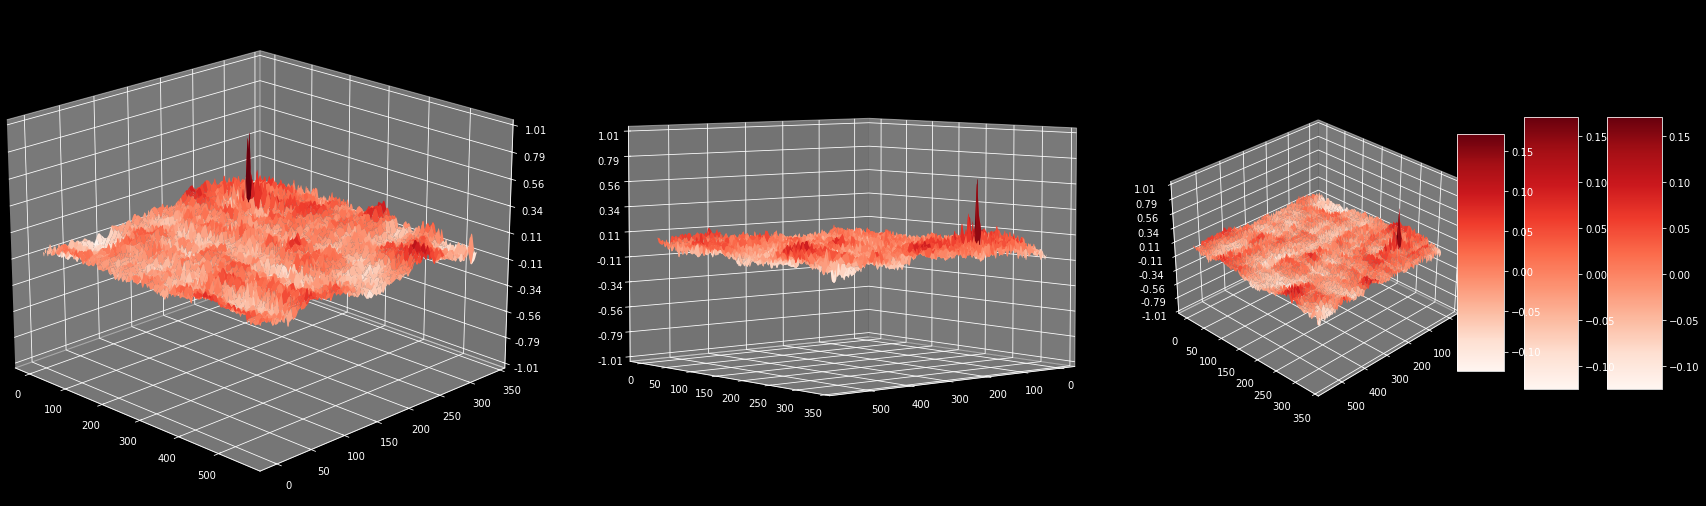

In [155]:
# Read images
img_rgb = cv2.imread(PATH_FILE_PLATES)
template = cv2.imread(PATH_FILE_PLATE_1)

# Do the matching
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
covarMatrix = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)

# Build grid
meshX = np.arange(0, covarMatrix.shape[1], 1)
meshY = np.arange(0, covarMatrix.shape[0], 1)

# Plot surfaces
plot3dSurfacesGrid(
    surfaces=[(meshX, meshY, covarMatrix)],
    gridRows = 1, gridCols = 3,
    colHeight = 10, colWidth = 10,
    positions=[(-45, 20, 9), (50, 5, 10), (45, 30, 8)]
)

## Template Matching Class

In [ ]:
class TemplateMatching():
    '''
        TODO: 2021-10-27 - ADD Description
    '''

    __img = np.array([])
    __template = np.array([])
    __correlation = np.array([])

    def __init__(self, imgPath: str, templatePath: str) -> None:
        self.__img = self.__readGrayScaleImg(imgPath)
        self.__template = self.__readGrayScaleImg(templatePath)

    def match(self):
        '''
            TODO: 2021-10-27 - ADD Description
        '''

        self.__correlation = cv2.matchTemplate(self.__img, self.__template, cv2.TM_CCOEFF_NORMED)
        return self

    def getCorrelation(self) -> np.array:
        '''
            TODO: 2021-10-27 - ADD Description
        '''
        
        return self.__correlation

    def drawRectangle(self, topLeft: tuple, bottomRight: tuple):
        '''
            TODO: 2021-10-27 - ADD Description
        '''
        
        cv2.rectangle(self.__img, topLeft, bottomRight, (255, 0, 0), 1) 
        return self

    def __readGrayScaleImg(self, path: str) -> np.array:
        '''
            TODO: 2021-10-26 - ADD Description
        '''

        imgBgr = cv2.imread(path)
        return np.array(cv2.cvtColor(imgBgr, cv2.COLOR_BGR2GRAY))


In [ ]:
foo = np.array([[1], [1]])
foo = np.array([[1]])
foo.ndim